# Deteccion Heterodina
## Hamiltoniano del sistema 
\begin{equation}
    H_{\text{sys}} = \Delta \, \sigma_+ \sigma_- + \frac{1}{2} \Omega \, (\sigma_+ + \sigma_-) 
\end{equation} 
## Hamiltoniano de la deteccion heterodina
\begin{equation}
    H_Z = H_{\text{sys}} + i \left( \gamma \langle \bar{\sigma}_+ \rangle_c + \sqrt{\gamma }\eta_z Z(t) \right) \sigma_-
\end{equation} 

## Incremento de Weiner complejo 
\begin{align}
    \eta Z &= \frac{dZ}{dt} \\
    dZ &= e^{i \omega' t} \, dW = \frac{1}{\sqrt{2}} \left( dW_1 + i \, dW_2 \right)
\end{align}

## Forma alternativa de las ecuaciones
\begin{equation}
    I_{Zc}(t) = \gamma \langle \bar{\sigma}_+ \rangle_c + \sqrt{\gamma }\eta_z \, Z
\end{equation}

\begin{equation}
    \frac{d|\Psi_c\rangle}{dt} = H_Z |\Psi_c\rangle
\end{equation}

\begin{equation}
    \frac{d|\Psi_c\rangle}{dt} = -i \left( H_{\text{sys}} + I_{Zc}(t) \sigma_- \right) |\Psi_c\rangle
\end{equation} 

In [19]:
sm*sp

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [145]:
# Deteccion heterodina
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1          # Tasa de detección
t_max = 30        # Tiempo de simulación
dt = 0.01            # Paso de tiempo
Omega = 1            # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 8         # Desintonía
num_traj = 5000     # Número de trayectorias


#Eficiencia del detector
eta=1

# Operadores cuánticos
sm = qt.destroy(2)    # σ-
sp = sm.dag()         # σ+
Pe = sp * sm          

# Hamiltoniano del sistema (Rabi) CORREGIDO
H_sys = Delta * sp * sm + 0.5 * Omega * (sp + sm) ##  [1]

# Función para una trayectoria estocástica con fase ϕ
def simulate_trajectory():
    
    psi_t = qt.basis(2, 0).unit()              # Estado inicial |g⟩
    pop_exc = []                               # Población del estado excitado
    photocurrent = []                          # Fotocorriente para esta trayectoria
    
    
    for i in range(steps):
        # Valor esperado de σ_ϕ
        
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = np.random.normal(0, np.sqrt(dt))
        dZ = (dW1 + 1j * dW2) / np.sqrt(2)
        eta_Z = dZ / (dt*eta)
        
        I_t = gamma * qt.expect(sp, psi_t) + np.sqrt(gamma) * eta_Z
        exp_factor = np.exp(1j * Delta * dt)

        photocurrent.append(I_t)
        # Término de retroalimentación (depende de ϕ)
        H_feedback = 1j*I_t*sm
        
        H_total = H_sys + H_feedback ## [2]
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))
    
    return pop_exc, photocurrent


results = {}

# Arrays para almacenar resultados
trajectories_pop = np.zeros((num_traj, steps))
trajectories_I = np.zeros((num_traj, steps), dtype=np.complex128)

for k in range(num_traj):
    pop, I = simulate_trajectory()
    trajectories_pop[k, :] = pop
    trajectories_I[k, :] = I
    print(f"Simulacion DHt: Trayectoria {k+1}/{num_traj}", end="\r")

# Promedios
avg_pop = np.mean(trajectories_pop, axis=0)
avg_I = np.mean(trajectories_I, axis=0)

results = {
    'avg_pop': avg_pop,
    'avg_I': avg_I,
    'trajectories_I': trajectories_I  # Opcional: guardar todas las trayectorias
}



In [142]:
results['trajectories_I'].shape

(100, 3000)

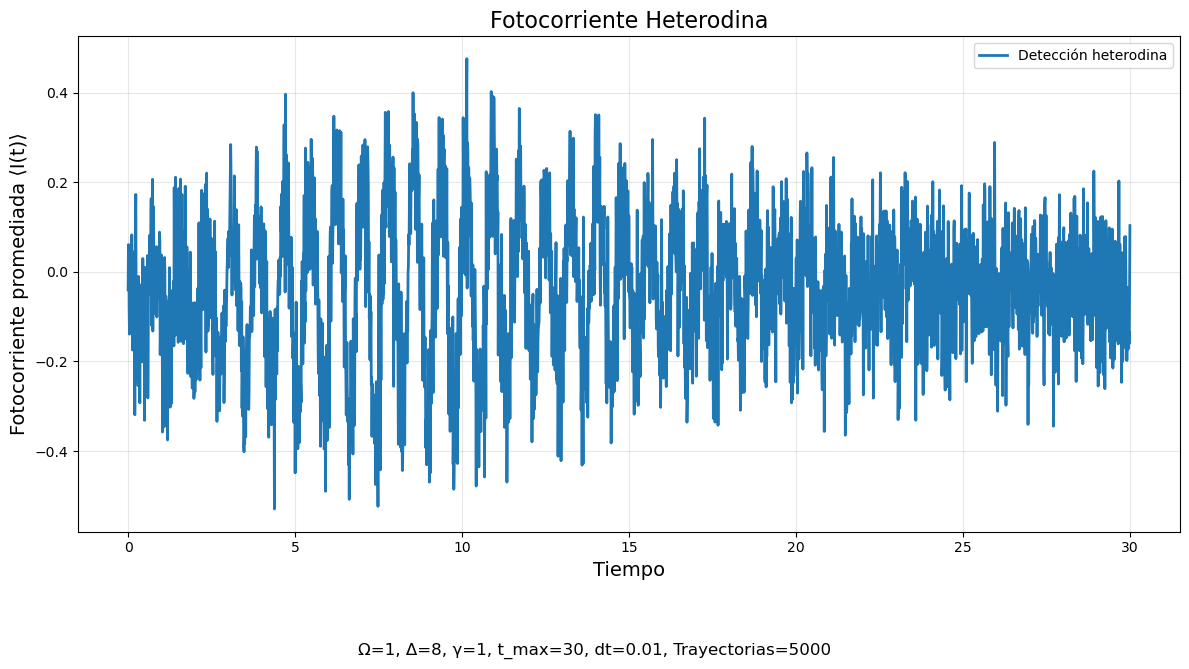

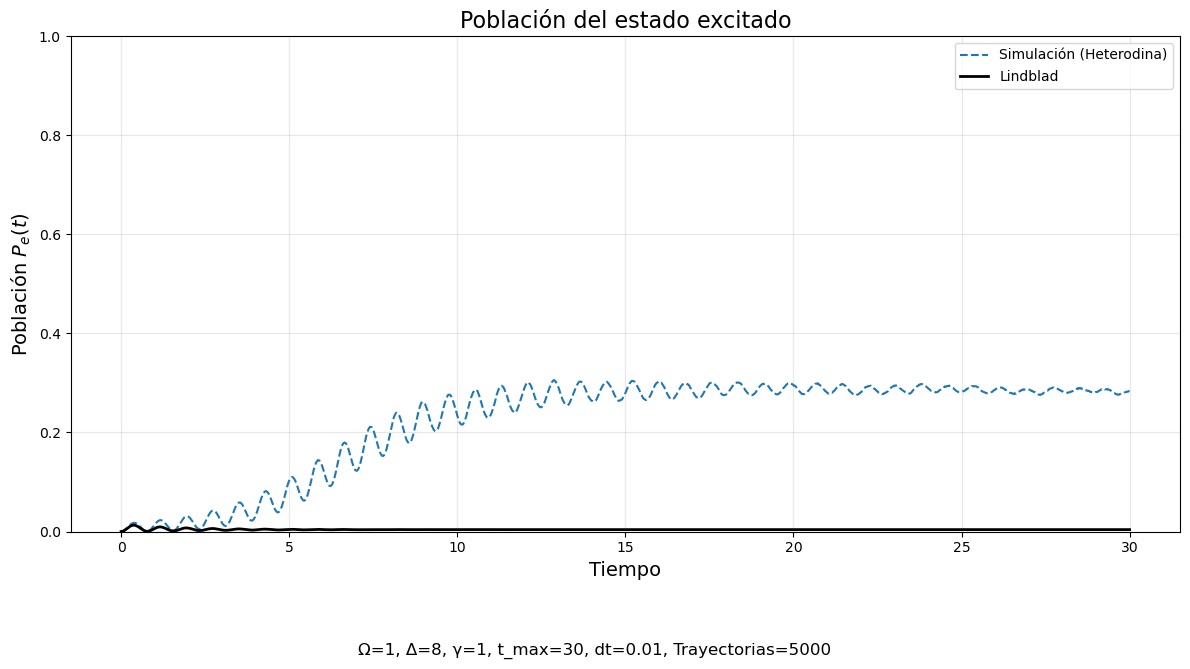

In [146]:
# Gráfico de fotocorrientes promediadas
plt.figure(figsize=(12, 6))
times = np.linspace(0, t_max, steps)
plt.plot(times, results['avg_I'], label="Detección heterodina", linewidth=2)

# Estilos de texto
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Fotocorriente promediada ⟨I(t)⟩", fontsize=14)
plt.title("Fotocorriente Heterodina", fontsize=16)

# Pie de figura con parámetros
plt.figtext(0.5, -0.1, f"Ω={Omega}, Δ={Delta}, γ={gamma}, t_max={t_max}, dt={dt}, Trayectorias={num_traj}",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Comparar con ecuación maestra para P_e(t)
plt.figure(figsize=(12, 6))
plt.plot(times, results['avg_pop'], '--', label='Simulación (Heterodina)')

# Ecuación maestra (Lindblad)
c_ops = [np.sqrt(gamma) * sm]
rho0 = qt.ket2dm(qt.basis(2, 0))
result_me = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
plt.plot(times, result_me.expect[0], 'k-', label='Lindblad', linewidth=2)

# Estilos de texto
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Población $P_e(t)$", fontsize=14)
plt.title("Población del estado excitado", fontsize=16)
plt.ylim(0,1)
# Pie de figura con parámetros
plt.figtext(0.5, -0.1, f"Ω={Omega}, Δ={Delta}, γ={gamma}, t_max={t_max}, dt={dt}, Trayectorias={num_traj}",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


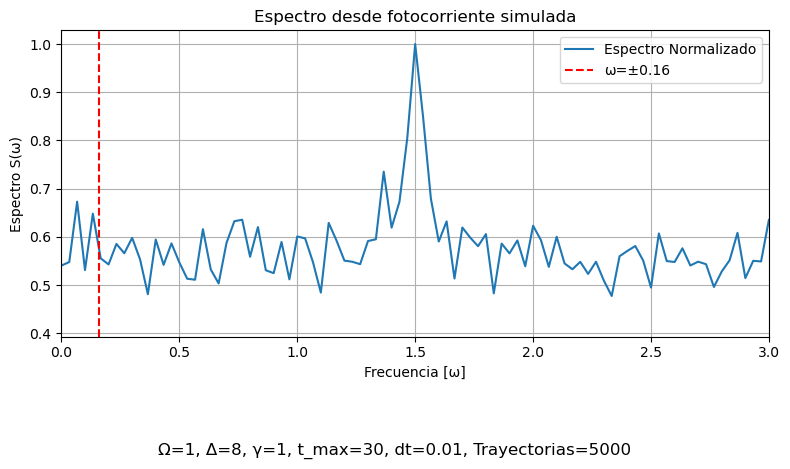

In [153]:
# Graficar
plt.figure(figsize=(8, 4))
plt.plot(freqs, np.real(S_w) / np.max(np.real(S_w)), label="Espectro Normalizado")
plt.xlabel("Frecuencia [ω]")
plt.ylabel("Espectro S(ω)")
plt.title("Espectro desde fotocorriente simulada")
plt.grid(True)
plt.axvline(x=Omega/(2*np.pi), color='r', linestyle='--', label=f'ω=±{Omega/(2*np.pi):.2f}')
plt.axvline(x=-Omega/(2*np.pi), color='r', linestyle='--')
plt.xlim(0, 3)
plt.legend()

# Parámetros de simulación en el pie de figura
sim_params = f"Ω={Omega}, Δ={Delta}, γ={gamma}, t_max={t_max}, dt={dt}, Trayectorias={num_traj}"
plt.figtext(0.5, -0.15, sim_params, wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()


In [25]:
# Convertir frecuencias a radianes por segundo
omega = 2 * np.pi * freqs

# Espectro normalizado (módulo o parte real según prefieras)
S_real = np.real(S_w)
S_norm = S_real / np.max(S_real)

# Índice del pico máximo
idx_max = np.argmax(S_norm)

# Frecuencia del pico más alto
omega_peak = omega[idx_max]
print(f"Frecuencia pico más angosto: ω = {omega_peak:.3f} rad/s")

Frecuencia pico más angosto: ω = 0.000 rad/s


In [29]:

# Altura media máxima
half_max = 0.5

# Buscar todos los cruces donde el espectro cruza la mitad del valor máximo
indices = np.where(S_norm >= half_max)[0]

# Obtener las frecuencias correspondientes
omega_half = omega[indices]

# Calcular el ancho total
fwhm = omega_half[-1] - omega_half[0]
print(f"Ancho del pico (FWHM): {fwhm:.3f} hz")

Ancho del pico (FWHM): 0.000 hz


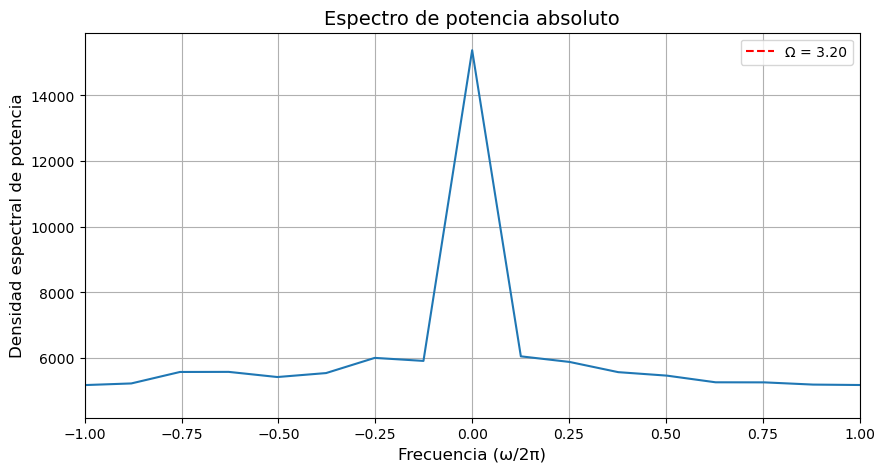

In [34]:
from scipy.signal import correlate
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt

num_traj, steps = trajectories_I.shape

# 1. Cálculo de la autocorrelación sin normalizar
autocorr_total = np.zeros(2*steps - 1, dtype=np.complex128)

for k in range(num_traj):
    I = trajectories_I[k, :]  # Fotocorriente compleja
    autocorr = correlate(I, I, mode='full')  # Autocorrelación sin normalizar
    autocorr_total += autocorr

autocorr_avg = autocorr_total / num_traj  # Promedio sobre trayectorias

# 2. Selección de retardos positivos (sin normalizar)
positive_lags = np.arange(-steps + 1, steps) * dt >= 0
autocorr_pos = autocorr_avg[positive_lags]

# 3. Transformada de Fourier (conservando unidades físicas)
S_w = fftshift(fft(autocorr_pos * dt))  # ¡Multiplicar por dt para unidades correctas!
freqs = fftshift(fftfreq(len(autocorr_pos), dt))

# 4. Graficar el espectro ABSOLUTO (sin normalizar)
plt.figure(figsize=(10, 5))
plt.plot(2*np.pi*freqs, np.real(S_w))  # Quitamos la normalización
plt.xlabel("Frecuencia (ω/2π)", fontsize=12)
plt.ylabel("Densidad espectral de potencia", fontsize=12)
plt.title("Espectro de potencia absoluto", fontsize=14)
plt.grid(True)
plt.axvline(x=Omega, color='r', linestyle='--', label=f'Ω = {Omega:.2f}')
plt.axvline(x=-Omega, color='r', linestyle='--')
plt.xlim(-1, 1)
plt.legend()
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes:
# freqs_d, S_w_d: Espectro angosto (pico en ~1.3, base en 0.6)
# freqs, S_w: Espectro ancho (pico en 0, base en 0.4)

# 1. Ajustar el desplazamiento en X del espectro angosto
desplazamiento_x = freqs_d[np.argmax(S_w_d)]    # Valor donde está el pico del espectro angosto
freqs_d_centrado = freqs_d - desplazamiento_x
desplazamiento_x

NameError: name 'freqs_d' is not defined

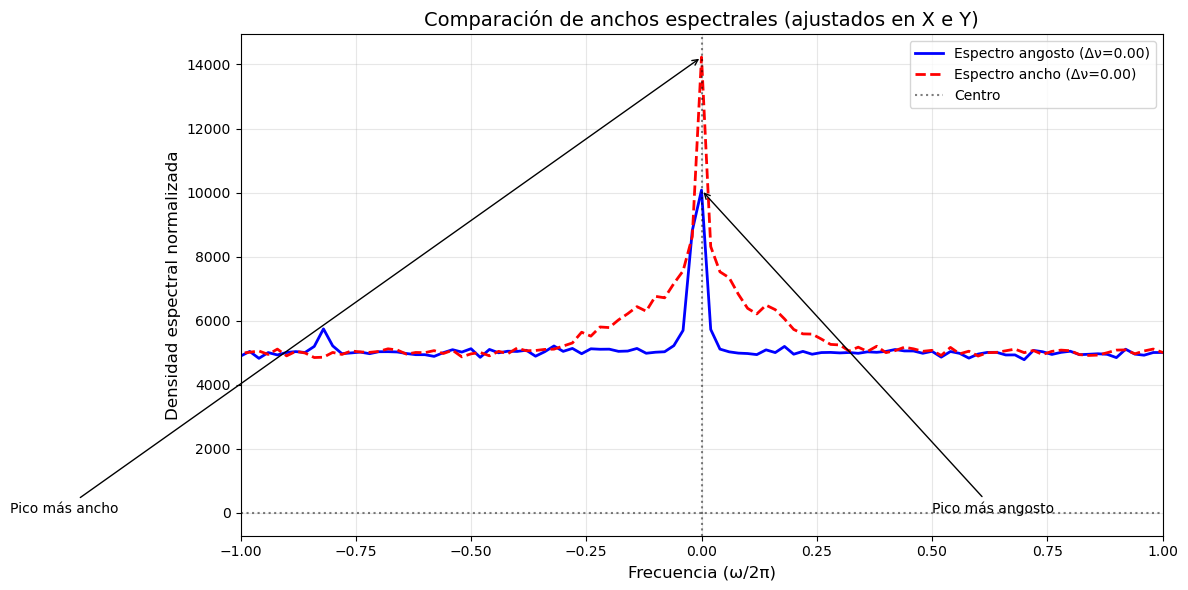

In [83]:


# 2. Ajustar niveles base en Y
base_angosto = 0.6  # Nivel base del espectro angosto
base_ancho = 0.4    # Nivel base del espectro ancho

# Restamos las bases y reescalamos para que empiecen en 0
S_w_d_ajustado = S_w_d - base_angosto
S_w_ajustado = np.real(S_w) - base_ancho

# 3. Opcional: Normalizar amplitudes para comparación visual
pico_angosto = np.max(S_w_d_ajustado)
pico_ancho = np.max(S_w_ajustado)

S_w_d_normalizado = S_w_d_ajustado
S_w_normalizado = S_w_ajustado

# 4. Graficación comparativa
plt.figure(figsize=(12, 6))

# Graficar ambos espectros ajustados
plt.plot(freqs_d_centrado, S_w_d_normalizado, 'b-', linewidth=2, 
         label=f'Espectro angosto (Δν={1/np.max(S_w_d_normalizado):.2f})')
plt.plot(freqs, S_w_normalizado, 'r--', linewidth=2, 
         label=f'Espectro ancho (Δν={1/np.max(S_w_normalizado):.2f})')

# Líneas de referencia
plt.axhline(y=0, color='k', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='k', linestyle=':', alpha=0.5, label='Centro')

# Ajustes estéticos
plt.xlabel("Frecuencia (ω/2π)", fontsize=12)
plt.ylabel("Densidad espectral normalizada", fontsize=12)
plt.title("Comparación de anchos espectrales (ajustados en X e Y)", fontsize=14)
plt.grid(True, alpha=0.3)

# Resaltar diferencia de anchura
plt.xlim(-1, 1)  # Ajustar según necesidad
#plt.ylim(-0.1, 1.1)

# Leyenda mejorada
plt.legend(loc='upper right', fontsize=10)

# Añadir anotaciones
plt.annotate('Pico más angosto', xy=(0, np.max(S_w_d_normalizado)), 
             xytext=(0.5, 0.8), arrowprops=dict(arrowstyle='->'))
plt.annotate('Pico más ancho', xy=(0, np.max(S_w_normalizado)), 
             xytext=(-1.5, 0.6), arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()